<a href="https://colab.research.google.com/github/alex-bolshunov/Plant-Disease-Detection/blob/main/plant_disease_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [320]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [321]:
class Models_metrics:
  def __init__(self):
    self.metrics_dict = {}

  def get_metrics_dict(self):
    return self.metrics_dict

  def get_average_time(self, model, X_test, iter = 100, p = 8):
    if iter < 1: iter = 1
    start = time.time()
    for _ in range(iter): model.predict(X_test)
    end = time.time()
    return round((end - start) / iter, p)

  def set_average_time(self, name, model, X_test, iter = 100):
    self.metrics_dict[name]["average time"] = self.get_average_time(model, X_test, iter)

  def calculate_metrics(self, y_test, y_pred, average = "weighted"):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1_score":f1}

  def update(self, name, y_test, y_pred):
    self.metrics_dict[name] = self.calculate_metrics(y_test, y_pred)

  def print_metrics(self, name, p = 5):
    print(f"Model name: {name}")
    for key, value in self.metrics_dict[name].items():
      print(f"{key.capitalize()}: {round(value, p)}.")

  def plot_confucion_matrix(self, y_test, y_pred, title = "", labels = ("Late Blight", "Early Blight", "Healthy"), cmap = "Blues", save_fig = False, path = ""):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=labels)
    cm_display.plot(cmap=cmap)
    if title: plt.title(title)
    if save_fig and path != "": plt.savefig(path)
    plt.show();

  def plot_roc_curve(self, y_test, y_scores, name = "", save_fig = False, path = ""):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray')
    plt.fill_between(fpr, tpr, 0, color='lightblue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ' + name)
    plt.legend(loc='lower right')
    plt.grid(alpha = 0.3)
    if save_fig and path != "": plt.savefig(path)
    plt.show();

  def plot_precision_recall(self, y_test, y_scores, name = "", save_fig = False, path = ""):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, color='blue', label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve " + name)
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    if save_fig and path != "": plt.savefig(path)
    plt.show();



In [322]:
#constants
N_ROWS = 3
RANDOM_STATE = 42
TEST_SIZE = 0.25
IMG = "image_path"
LBL = "label"

In [323]:
!curl "https://raw.githubusercontent.com/alex-bolshunov/Plant-Disease-Detection/refs/heads/main/data/plants_potatos.csv" -o plants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.9M  100 10.9M    0     0  14.5M      0 --:--:-- --:--:-- --:--:-- 14.5M


In [324]:
df = pd.read_csv("plants.csv")

In [325]:
df.head(N_ROWS)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,0.814920,0.149626,0.030800,1.564548,0.175093,0.887551,0.044878,0.000000,0.195844,0.010599,...,0.339108,0.171852,3.850002,0.916647,0.003811,0.493870,0.147042,0.022846,0.920335,Potato___healthy
1,1.225895,0.125868,0.991248,1.133614,0.198930,1.805408,0.373276,0.085032,0.804247,0.002913,...,0.112412,0.462129,2.261460,0.979156,0.407353,0.017057,0.008000,0.053684,0.452296,Potato___healthy
2,0.240103,0.297077,0.413395,1.844378,0.907214,1.877417,0.003620,0.000000,0.553658,0.085272,...,0.159531,0.193687,3.051004,1.603528,0.016442,0.695276,0.117747,0.038980,1.049156,Potato___healthy


In [326]:
#encode lables
encoder = LabelEncoder()

df.loc[:, LBL] = encoder.fit_transform(df.loc[:, LBL])

In [327]:
#initialize metrics obj
metrics = Models_metrics()

# SVM

In [328]:
#get features and labels
robust = RobustScaler()

X, y = robust.fit_transform(df.drop(LBL, axis = 1)), df.loc[:, LBL].to_numpy().astype("int")

In [329]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [330]:
#define and train a model
svm = SVC(kernel = "rbf")

svm.fit(X_train, y_train)

SVC()

In [331]:
#predict class
y_pred = svm.predict(X_test)

In [332]:
#get metrics
name = "svm"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, svm, X_test)
metrics.print_metrics(name)

Model name: svm
Accuracy: 0.98327.
Precision: 0.98331.
Recall: 0.98327.
F1_score: 0.98271.
Average time: 0.16739.


In [333]:
#get y scores
y_scores = svm.decision_function(X_test)

In [334]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precision_recall_curve_name.jpg")

In [335]:
#plot roc curve
#metrics.plot_roc_curve(y_test, y_scores, name.capitalize(), save_fig = True, path = "roc_curve_svm.jpg")

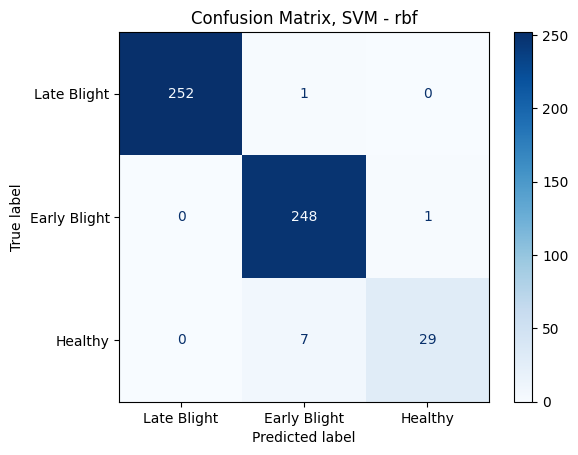

In [336]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, "Confusion Matrix, SVM - rbf", save_fig = True, path = "confusion_matrix_svm.jpg")

# Decision Tree

In [337]:
#get features and labels
X, y = df.drop(LBL, axis = 1), df.loc[:, LBL].to_numpy().astype("int")

In [338]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [339]:
#define and train a model
max_depth = 5
decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [340]:
#predict
y_pred = decision_tree.predict(X_test)

In [341]:
#get metrics
name = "decision tree"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, decision_tree, X_test)
metrics.print_metrics(name)

Model name: decision tree
Accuracy: 0.85316.
Precision: 0.84978.
Recall: 0.85316.
F1_score: 0.85115.
Average time: 0.00651.


In [342]:
#get depth
depth = decision_tree.get_depth()
print(f"The depth of the model is {depth}.")

The depth of the model is 17.


In [343]:
#get y scores
y_scores = decision_tree.predict_proba(X_test)[:, 1]

In [344]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precison_recall_curve_decision_tree.jpg")

In [345]:
#plot roc curve
#metrics.plot_roc_curve(y_test, y_scores, name.capitalize(), save_fig = True, path = "roc_curve_decision_tree.jpg")

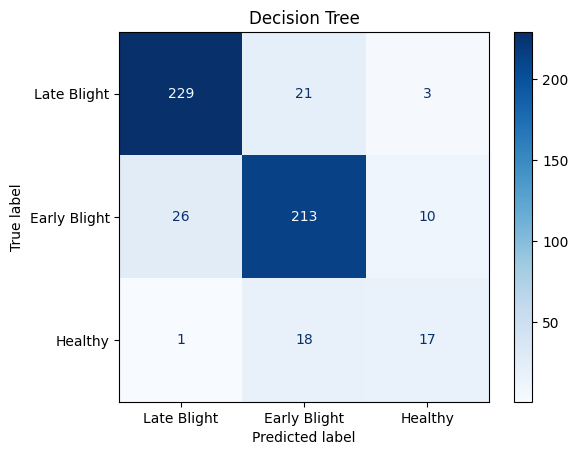

In [346]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, "Decision Tree", save_fig = True, path = "confusion_matrix_decision_tree.jpg")

# Naive Bayes

In [347]:
#get features and labels
X, y = df.drop(LBL, axis = 1), df.loc[:, LBL].to_numpy().astype("int")

In [348]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [349]:
#define and train model
naive_bayes = GaussianNB()

naive_bayes.fit(X_train, y_train)

GaussianNB()

In [350]:
#predict
y_pred = naive_bayes.predict(X_test)

In [351]:
#get metrics
name = "naive bayes"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, naive_bayes, X_test)
metrics.print_metrics(name)

Model name: naive bayes
Accuracy: 0.92937.
Precision: 0.94077.
Recall: 0.92937.
F1_score: 0.93229.
Average time: 0.00763.


In [352]:
#get y scores
y_scores = naive_bayes.predict_proba(X_test)[:, 1]

In [353]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precision_recall_curve_naive_bayes.jpg")

In [354]:
#plot roc curve
#metrics.plot_roc_curve(y_test, y_scores, name.capitalize(), save_fig = True, path = "roc_curve_naive_bayes.jpg")

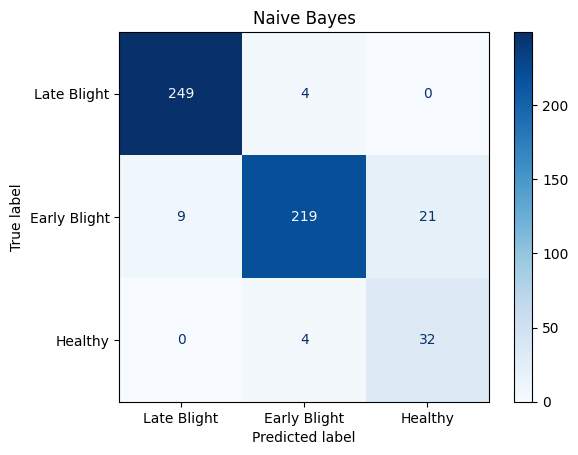

In [355]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, "Naive Bayes", save_fig = True, path = "confusion_matrix_naive_bayes.jpg")

# KNN

In [356]:
#get features and labels
robust = RobustScaler()

X, y = robust.fit_transform(df.drop(LBL, axis = 1)), df.loc[:, LBL].to_numpy().astype("int")

In [357]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

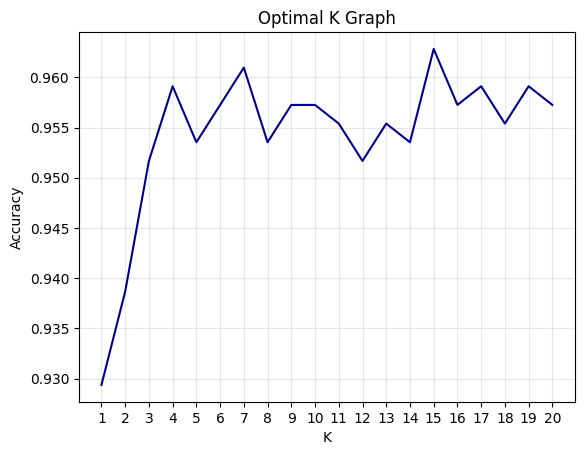

In [358]:
acc = []
k_values = np.arange(1,21)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

plt.plot(k_values, acc, c = "darkblue", zorder = 5)
plt.xticks(k_values)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Optimal K Graph")
plt.grid(alpha = 0.3, zorder = 1)
plt.savefig("knn_optimal_k.jpg")
plt.show()


In [359]:
#define and train model
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [360]:
#predict
y_pred = knn.predict(X_test)

In [361]:
#get metrics
name = "knn"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, knn, X_test)
metrics.print_metrics(name)

Model name: knn
Accuracy: 0.96097.
Precision: 0.96256.
Recall: 0.96097.
F1_score: 0.9613.
Average time: 0.03903.


In [362]:
#get y scores
y_scores = knn.predict_proba(X_test)[:, 1]

In [363]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precision_recall_knn.jpg")

In [364]:
#plot roc curve
#metrics.plot_roc_curve(y_test, y_scores, name.capitalize(), save_fig = True, path = "roc_curve_knn.jpg")

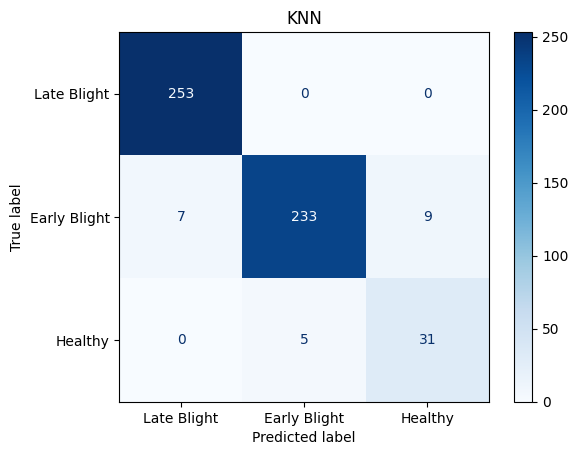

In [365]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, "KNN", save_fig = True, path = "confusion_matrix_knn.jpg")

# Perceptron

In [366]:
#get features and labels
X, y = df.drop(LBL, axis = 1), df.loc[:, LBL].to_numpy().astype("int")

In [367]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [368]:
#define and train model
perceptron = Perceptron()

perceptron.fit(X_train, y_train)

Perceptron()

In [369]:
#predict
y_pred = perceptron.predict(X_test)

In [370]:
#get metrics
name = "perceptron"

metrics.update(name, y_test, y_pred)
metrics.set_average_time(name, perceptron, X_test)
metrics.print_metrics(name)

Model name: perceptron
Accuracy: 0.97398.
Precision: 0.97489.
Recall: 0.97398.
F1_score: 0.97406.
Average time: 0.00697.


In [371]:
#get y scores
y_scores = perceptron.decision_function(X_test)

In [372]:
#plot precision recall curve
#metrics.plot_precision_recall(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "precision_recall_curve_perceptron.jpg")

In [373]:
#plot roc curve
#metrics.plot_roc_curve(y_test, y_scores, name = name.capitalize(), save_fig = True, path = "roc_curve_perceptron.jpg")

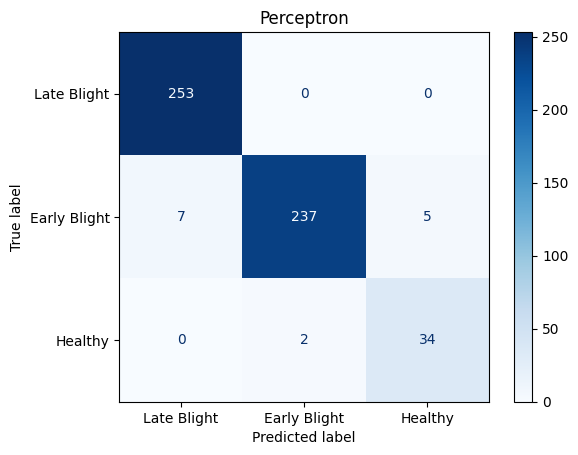

In [374]:
#plot confusion matrix
metrics.plot_confucion_matrix(y_test, y_pred, name.capitalize(), save_fig = True, path = "confusion_matrix_perceptron.jpg")

# All models

In [375]:
df_metrics = pd.DataFrame(metrics.get_metrics_dict()).T
df_metrics

,accuracy,precision,recall,f1_score,average time
svm,0.983271,0.983306,0.983271,0.982710,0.167394
decision tree,0.853160,0.849778,0.853160,0.851153,0.006508
naive bayes,0.929368,0.940771,0.929368,0.932292,0.007631
knn,0.960967,0.962560,0.960967,0.961299,0.039030
perceptron,0.973978,0.974887,0.973978,0.974060,0.006965


In [376]:
df_metrics_agg_columns = ["mean", "max_value_model", "max", "min_value_model", "min"]
df_metrics_agg = df_metrics.agg(["mean", "idxmax", "max", "idxmin", "min"]).T
df_metrics_agg.columns = df_metrics_agg_columns
df_metrics_agg

,mean,max_value_model,max,min_value_model,min
accuracy,0.940149,svm,0.983271,decision tree,0.85316
precision,0.942261,svm,0.983306,decision tree,0.849778
recall,0.940149,svm,0.983271,decision tree,0.85316
f1_score,0.940303,svm,0.98271,decision tree,0.851153
average time,0.045506,svm,0.167394,decision tree,0.006508


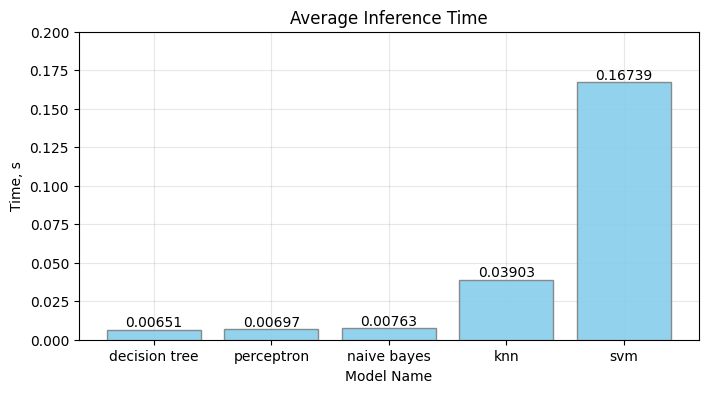

In [377]:
#number of instances is
average_time = df_metrics["average time"]

order_asc = average_time.argsort().values
xticks_labels = np.array([average_time.index[i] for i in order_asc])
height = np.array([average_time.values[i] for i in order_asc])

y_limit = (0, np.round(height.max() + height.max() * 0.2, 2))

fig = plt.figure(figsize = (8,4))

bars = plt.bar(xticks_labels, height, edgecolor = "grey", color = "skyblue",  alpha = 0.9, zorder = 5)

for bar in bars:
     h = bar.get_height()
     plt.text(bar.get_x() + bar.get_width() / 2, h, f'{round(h, 5)}', ha='center', va='bottom' )

plt.ylim(y_limit)
plt.grid(alpha = 0.3, zorder = 1)
plt.ylabel("Time, s")
plt.xlabel("Model Name")
plt.title("Average Inference Time")
plt.savefig("average_inference_time.jpg")
plt.show();
